In [1]:
# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import lsst.daf.butler as dafButler
butler1 = dafButler.Butler('/repo/main',  collections=['u/kherner/PREOPS-630_w36_default_bestSeeing_20210929',])
butler2 = dafButler.Butler('/repo/main', collections=['u/kherner/PREOPS-630_useScoreImageDetection_bestThird'])

In [3]:
score = butler2.get('bestThirdDiff_scoreExp', visit=11690, detector=57)
diff = butler1.get('bestThirdDiff_differenceExp', visit=11690, detector=57)

In [4]:
display1 = afwDisplay.Display(backend='firefly', frame=1, url='https://lsst-demo.ncsa.illinois.edu/firefly')
display2 = afwDisplay.Display(backend='firefly', frame=2, url='https://lsst-demo.ncsa.illinois.edu/firefly')
display1.mtv(score)
display2.mtv(diff)

In [5]:
src_default =  butler1.get('bestThirdDiff_diaSrc', visit=11690, detector=57)
src_preconv =  butler2.get('bestThirdDiff_diaSrc', visit=11690, detector=57)
df_default = src_default.asAstropy().to_pandas()
df_preconv = src_preconv.asAstropy().to_pandas()

In [6]:
from scipy.spatial import cKDTree
dist, ind = cKDTree(df_default[['coord_ra', 'coord_dec']].values).query(df_preconv[['coord_ra', 'coord_dec']].values,
                                                           k=1, distance_upper_bound=1./206265)
df_preconv['ind'] = ind
df_preconv['dist'] = dist*206265

merged = pd.merge(df_preconv, df_default, left_on='ind', right_index=True, 
                  suffixes=('_preconv', '_default'))

In [7]:
merged['flux_diff'] = merged['base_PeakLikelihoodFlux_instFlux_preconv'] - merged['base_PsfFlux_instFlux_default']
merged['flux_diff_err'] = np.sqrt(merged['base_PsfFlux_instFluxErr_default']**2 + 
                                  merged['base_PeakLikelihoodFlux_instFluxErr_preconv']**2)

Text(0, 0.5, 'PeakLikelihoodFlux - PsfFlux')

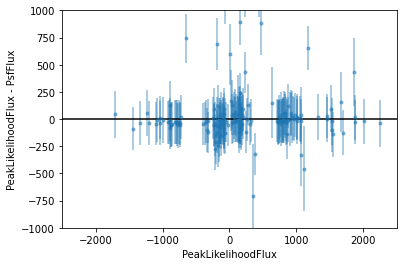

In [8]:
plt.errorbar(merged['base_PeakLikelihoodFlux_instFlux_preconv'],
            (merged['flux_diff']),
             yerr=merged['flux_diff_err'],
             fmt='.', alpha=0.5)
plt.axhline(0, color='k')
plt.xlim(-2500, 2500)
plt.ylim(-1000, 1000)
plt.xlabel('PeakLikelihoodFlux')
plt.ylabel('PeakLikelihoodFlux - PsfFlux')

Text(0, 0.5, 'Chi')

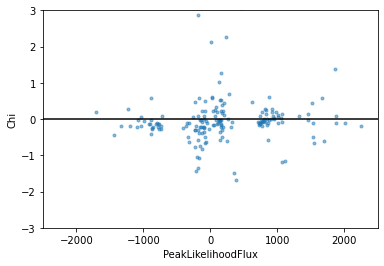

In [9]:
plt.plot(merged['base_PeakLikelihoodFlux_instFlux_preconv'], merged['flux_diff']/merged['flux_diff_err'],'.',
             alpha=0.5)
plt.axhline(0, color='k')
plt.xlim(-2500, 2500)
plt.ylim(-3, 3)
plt.xlabel('PeakLikelihoodFlux')
plt.ylabel('Chi')

In [10]:
outliers = merged[(np.abs(merged['flux_diff']) > merged['flux_diff_err'])]

In [11]:
for display in (display1, display2):
    with display.Buffering():
        for index, record in outliers.iterrows():
            if (
                record['base_PixelFlags_flag_offimage_default'] |
                record['base_PixelFlags_flag_edge_default'] |
                record['base_PixelFlags_flag_saturated_default'] | 
                record['base_PixelFlags_flag_bad_default'] | 
                record['base_PixelFlags_flag_suspect_default'] | 
                record['base_PixelFlags_flag_interpolatedCenter_default'] | 
                record['base_PixelFlags_flag_saturatedCenter_default'] | 
                record['base_PixelFlags_flag_crCenter_default'] | 
                record['base_PixelFlags_flag_suspectCenter_default'] 
                 ):
                display.dot('+', record['slot_Centroid_x_default'], record['slot_Centroid_y_default'], size=20, ctype='red')
            else:
                display.dot('o', record['slot_Centroid_x_default'], record['slot_Centroid_y_default'], size=20, ctype='yellow')
